In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

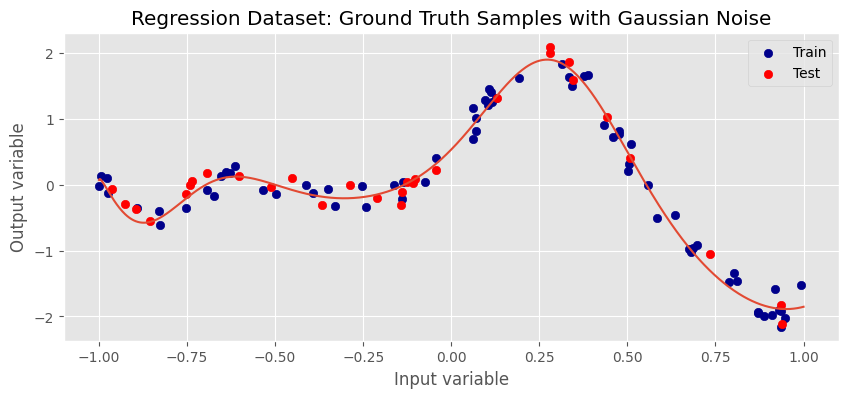

In [4]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)


In [48]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).








class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.LeakyReLU(negative_slope=0.1),
        noise_std=1.0,
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)

        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

In [49]:
bnn_model = MeanFieldBNN(1, [4, 4], 1, noise_std=0.15)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

MeanFieldBNN(
  (activation): LeakyReLU(negative_slope=0.1)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): LeakyReLU(negative_slope=0.1)
    (2): MeanFieldLayer()
    (3): LeakyReLU(negative_slope=0.1)
    (4): MeanFieldLayer()
  )
)


100%|██████████| 4000/4000 [03:05<00:00, 21.51it/s]


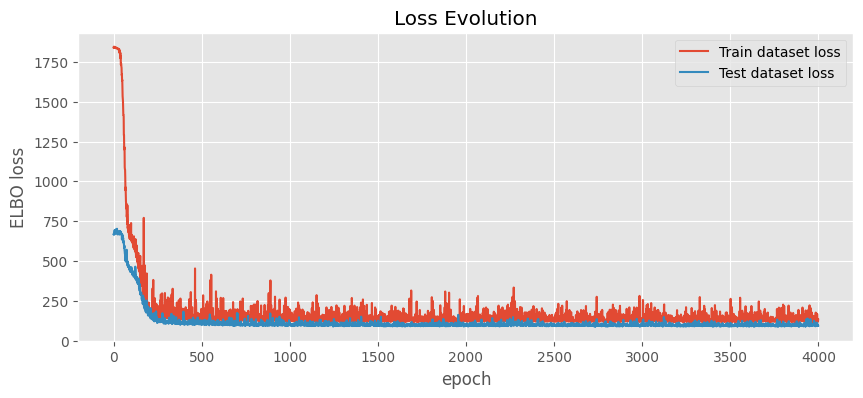

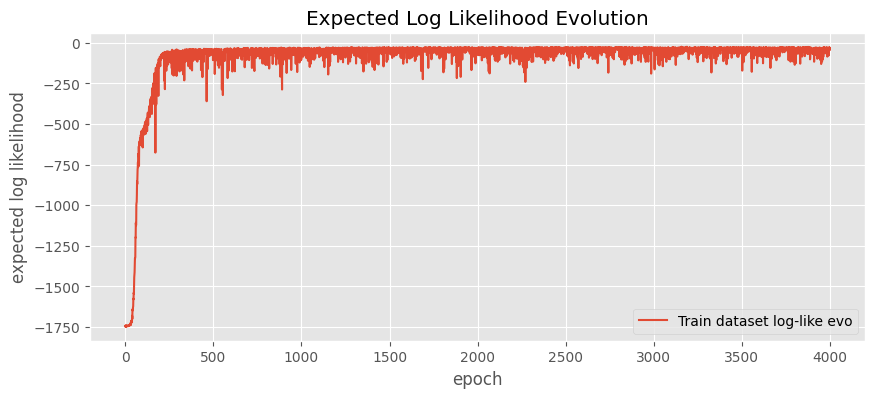

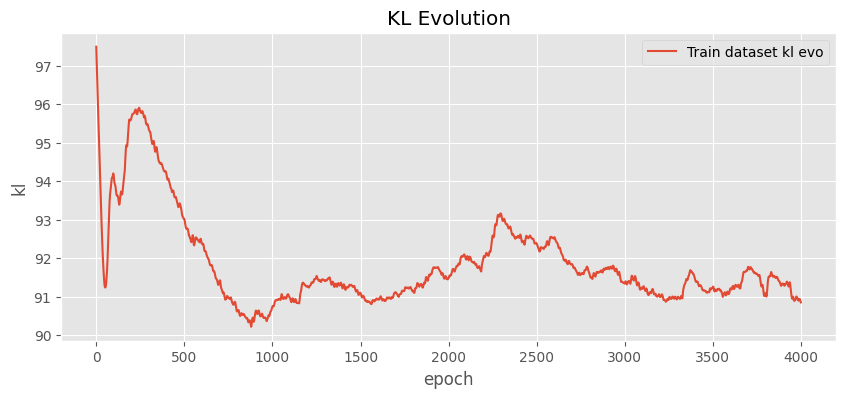

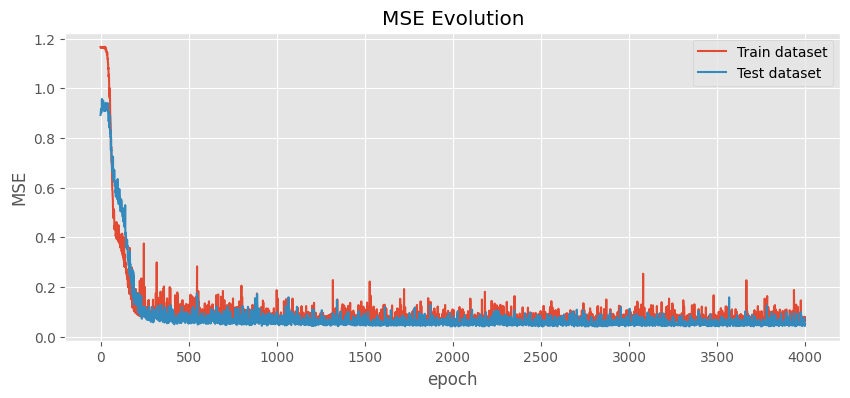

In [50]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(4000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

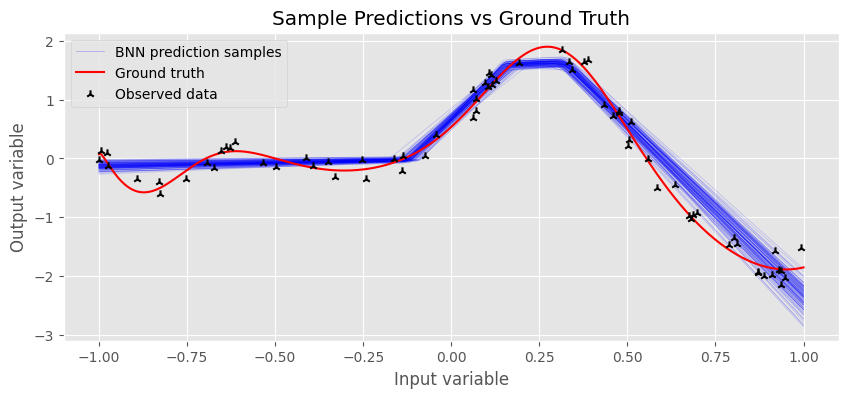

In [53]:
xs = np.linspace(-1, 1, 500)
num_samps = 100

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
plt.plot(xs, preds[0,...], color='blue', linewidth=0.5, alpha=0.3, label='BNN prediction samples')
plt.plot(xs, preds[1:,...].T, color='blue', linewidth=0.5, alpha=0.2)

ys = normalised_ground_truth(xs)
plt.title("Sample Predictions vs Ground Truth")
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

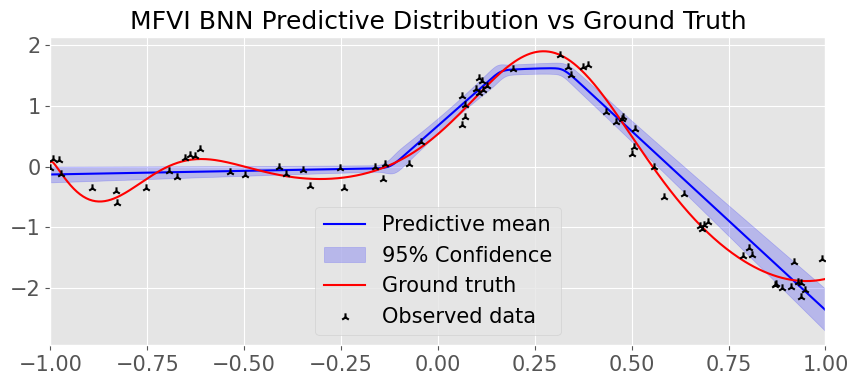

In [54]:
xs = np.linspace(-1, 1, 500)
num_samps = 1000

preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

ys = normalised_ground_truth(xs)
plt.title("MFVI BNN Predictive Distribution vs Ground Truth", fontsize=18)
plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
plt.legend(fontsize=15, loc='lower center')
plt.xlim([-1, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.grid()
plt.show()

In [55]:
bnn_model.network

ModuleList(
  (0): MeanFieldLayer()
  (1): LeakyReLU(negative_slope=0.1)
  (2): MeanFieldLayer()
  (3): LeakyReLU(negative_slope=0.1)
  (4): MeanFieldLayer()
)

In [21]:
bnn_model.network[0].w_mu_q

Parameter containing:
tensor([[ 0.3837, -2.3386, -2.1762,  1.3852]], requires_grad=True)

In [24]:
bnn_model.network[0].w_log_var_q

Parameter containing:
tensor([[-3.7409, -6.6673, -6.7885, -3.1488]], requires_grad=True)

In [25]:
bnn_model.network[0].b_mu_q

Parameter containing:
tensor([-0.2700,  0.9577,  0.9317,  0.2710], requires_grad=True)

In [27]:
bnn_model.network[0].b_log_var_q

Parameter containing:
tensor([-5.6137, -7.9571, -7.9525, -6.9524], requires_grad=True)

In [28]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm

In [29]:
class FullCovGaussianLayer(nn.Module):
    """Represents a full covariance Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_params = input_dim * output_dim + output_dim
        # Prior parameters p(theta)
        prior_std = 0.8 ### we can later add this as a parameter
        # prior_std = 1.1 ### we can later add this as a parameter

        mu_prior = torch.ones(input_dim * output_dim + output_dim)/20 # prior mean for all weights and biases
        cov_chol_prior = torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim) * prior_std

        self.register_buffer('prior_mean', mu_prior)
        self.register_buffer('prior_weight_cov_chol', cov_chol_prior)
        self.register_buffer('prior_cov_inv', 1/prior_std**2 * torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim))  

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = mu_prior
        self.cov_chol = cov_chol_prior

        # initialise lambda (not sure where this is used)
        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean


        # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl
    
    ## Maybe this instead wants to be in the network class and get passed to forward for each layer...might be neater
    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        """Propagates x through this layer by sampling weights from the posterior"""
        # assert (len(input.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        # assert input.shape[-1] == self.input_dim

        # num_samples = x.shape[0]

        weights = sampled_params[:self.input_dim * self.output_dim].view(self.output_dim, self.input_dim)
        biases = sampled_params[self.input_dim * self.output_dim:]
        return F.linear(input, weights, biases)
        # # rsample carries out reparameterisation trick for us   
        # weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # return x @ weights + biases # (num_samples, batch_size, output_dim).


In [30]:
class FullCovBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.LeakyReLU(negative_slope=0.1),
        noise_std=1.0,
    ):
        super(FullCovBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
    
        self.network = nn.ModuleList()

        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation)
    
    def sample_network_params(self):
        """
        Sample parameters for each layer and store them in a dictionary.
        """
        sampled_params = {}
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Sample params for this layer and store them
                sampled_params[i//2] = layer.sample_params()
        return sampled_params



    def forward(self, input, sampled_params):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        # Propagate x through the network with sampled parameters
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Get the corresponding sampled parameters for this layer
                sampled_param = sampled_params[i//2]  # Divide by 2 because activations are interspersed
                # Pass input x and the sampled parameters to the layer
                input = layer(input, sampled_param)
            else:
                # Apply activation function
                input = layer(input)  # Since it's an activation function, just apply it directly

        return input


    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl


In [31]:
def compute_param_gradients(net, input, targets, noise, K):
    # Initialise gradients
    gradients = {}

    # Loop through the layers in the network to initialize gradients
    for i, layer in enumerate(net.network):
        if isinstance(layer, FullCovGaussianLayer):  # Check if the layer is a FullCovGaussianLayer    
            # Initialize the gradient tensor for this layer (all zeros)
            gradients[i//2] = torch.zeros(layer.num_params, requires_grad=False) 
    for l in range(K):
        sampled_params = net.sample_network_params()  # Sample from q distribution with gradient tracking
        for param in sampled_params.values():
            if param.grad is not None:
                param.grad.zero_()

        output = net.forward(input, sampled_params)  # Forward pass

        for key, param in sampled_params.items():
            for i in range(output.shape[0]):
                output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True) ###why is this required? I feel like it shouldn't be
            gradients[key] += param.grad
            gradients[key] += net.network[key*2].prior_cov_inv @ (param - net.network[key*2].prior_mean) ##issue is that the key in a dict is a string, not a number. This is the current issue
    for key in gradients:
        gradients[key] /= K
    return gradients

In [32]:
def update_variational_params_choldate(net, input, targets, noise, K):
    gradients = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    alpha = 0.001
    gamma = 1
    
    alpha_prime = torch.tensor([1 / (1-alpha*gamma)])

    with torch.no_grad():
        for key, grad in gradients.items():
            grad = grad.unsqueeze(1)
            mu, chol = net.network[key*2].mean.unsqueeze(1), net.network[key*2].cov_chol
        
            lambda_1 = net.network[key*2].lambda_1.unsqueeze(1)
            v = alpha_prime * chol @ (chol.t() @ grad) #sigma_tilde @ g

            beta = - alpha / (1 + alpha * grad.t() @ v)
            beta = beta.item()
            chol = torch.sqrt(alpha_prime) * chol
        
            chol_tf = tf.convert_to_tensor(chol.numpy())
            v_tf = tf.convert_to_tensor(v.numpy())
            v_tf = tf.reshape(v_tf, [net.network[key*2].num_params])  # Shape (13,)

            # chol_updated_tf = tfp.math.cholesky_update(np.sqrt(1.2)*chol_tf, np.sqrt(1.2)*v_tf, multiplier=beta)
            chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)

            chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
            nu = grad.t() @ mu
            lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * grad

            net.network[key*2].lambda_1 = lambda_1.flatten()
            net.network[key*2].mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
            net.network[key*2].cov_chol = chol_updated # same here


In [33]:
BNN = FullCovBNN(1, [4, 4], 1, noise_std=0.15)

In [101]:
BNN.network[4].cov_chol = torch.diag(torch.tensor([0.0230, 0.0292, 0.0177, 0.0996,0.0187]))

In [102]:
BNN.network[4].cov_chol

tensor([[0.0230, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0292, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0177, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0996, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0187]])

In [99]:
torch.sqrt(torch.exp(bnn_model.network[4].w_log_var_q.reshape(4)))

tensor([0.0230, 0.0292, 0.0177, 0.0996], grad_fn=<SqrtBackward0>)

In [100]:
torch.sqrt(torch.exp(bnn_model.network[4].b_log_var_q))

tensor([0.0187], grad_fn=<SqrtBackward0>)

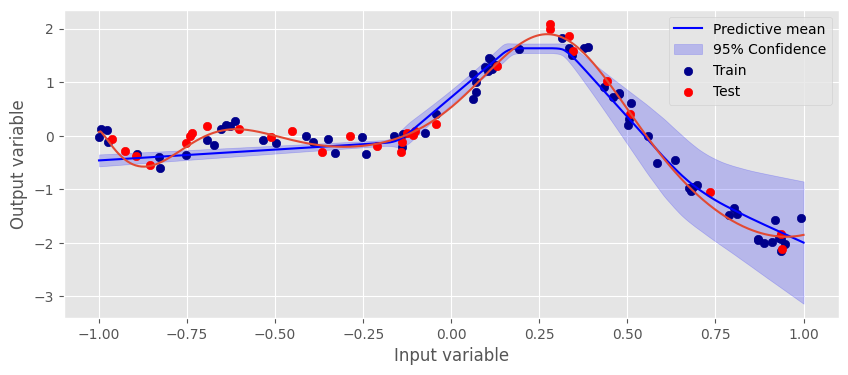

In [103]:
def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_network_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

Epoch 1


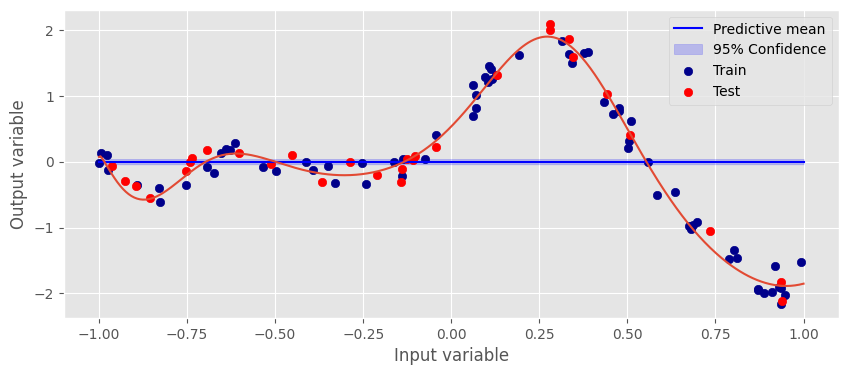

In [104]:
n_epochs = 1

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, 0.15, K=10)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)